## 1. Imports


In [33]:
import sys
sys.path.append('../')
from scripts.visualization_utils import impact_bar_plots
from scripts.evaluation_utils import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [37]:
data_path = '../data/results/test_2_balanced/'
#data_path = '../data/results/june1/'
#folders= ['dt','gnb','lgr','gbt']
folders = ['dt']

## 2. DI_plots and CSV

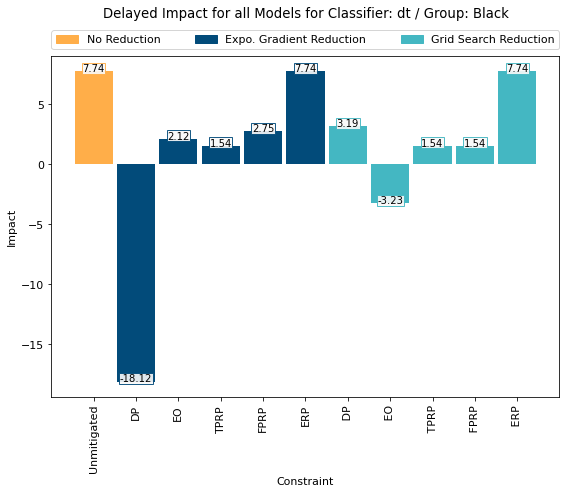

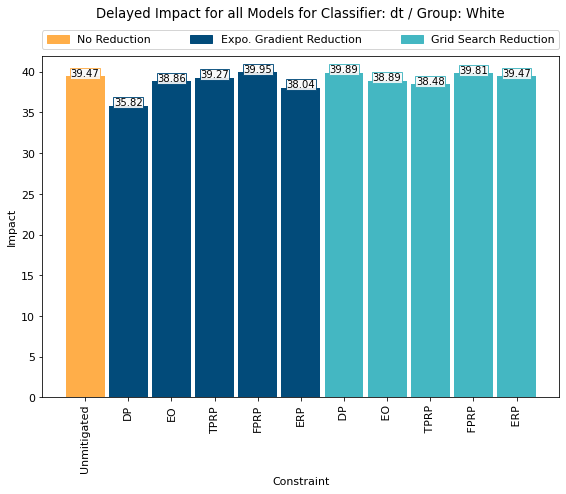

In [38]:
impact_bar_plots(data_path,'Black',folders)
impact_bar_plots(data_path,'White',folders)

In [39]:
impact_csvs(data_path,'Black', folders= ['dt','gnb','lgr','gbt'])
impact_csvs(data_path,'White', folders= ['dt','gnb','lgr','gbt'])

FileNotFoundError: [Errno 2] No such file or directory: '../data/results/test_2_balanced/gnb/gnb_black_results.csv'

## 3. FP/TP/TN/FN Ratios

In [40]:
types_ratios_csv(data_path,folders)

dt
Classifier:  dt 
 DataFrame: 
 ID        egdpB     egdpW     egeoB     egeoW    egerpB    egerpW   egfprpB  \
Value                                                                         
FN     0.026385  0.187692  0.053231  0.113231  0.089846  0.063615  0.055385   
FP     0.271308  0.019615  0.122923  0.036615  0.067154  0.068385  0.117692   
TN     0.392385  0.216154  0.540769  0.199154  0.596538  0.167385  0.546000   
TP     0.309923  0.576538  0.283077  0.651000  0.246462  0.700615  0.280923   

ID      egfprpW   egtprpB   egtprpW     gsdpB     gsdpW     gseoB     gseoW  \
Value                                                                         
FN     0.089769  0.051692  0.109538  0.057000  0.082538  0.042615  0.121154   
FP     0.041077  0.127615  0.035692  0.113923  0.045077  0.163923  0.032462   
TN     0.194692  0.536077  0.200077  0.549769  0.190692  0.499769  0.203308   
TP     0.674462  0.284615  0.654692  0.279308  0.681692  0.293692  0.643077   

ID       gserpB 

## 4. Score Distributions

Loading All Scores and splitting it into multiple dataframes

In [42]:
classifier_dfs = {}
dfs_b = {}
dfs_w = {}
dfs_eg = {}
dfs_gs = {}
for f in folders:
    path = f'{data_path}{f}/{f}_all_scores.csv'
    df = pd.read_csv(path)
    df = df.reset_index(drop=True)
    

    df_black = df.filter(like='B')
    df_white = df.filter(like='W')
    df_eg = pd.concat([df.iloc[:,:4],df.filter(like='eg')],axis=1)
    df_gs = pd.concat([df.iloc[:,:4],df.filter(like='gs')],axis=1)
    
    classifier_dfs[f] = df
    dfs_b[f] = df_black
    dfs_w[f] = df_white
    dfs_eg[f] = df_eg
    dfs_gs[f] = df_gs
print(dfs_b['dt'])

       testB  unmitB  egdpB  egeoB  egtprpB  egfprpB  egerpB  gsdpB  gseoB  \
0        763     838    838    838      838      838     838    838    838   
1        710     785    785    785      785      785     785    785    785   
2        390     390    390    390      390      390     390    390    390   
3        662     737    737    737      737      737     737    737    737   
4        475     475    475    475      475      475     475    475    475   
...      ...     ...    ...    ...      ...      ...     ...    ...    ...   
12995    452     452    302    452      452      452     452    452    452   
12996    475     475    475    475      475      475     475    475    475   
12997    483     483    483    483      483      483     483    483    483   
12998    511     511    361    511      511      511     511    511    511   
12999    511     511    361    511      511      511     511    511    511   

       gstprpB  gsfprpB  gserpB  
0          838      838     8

Checking if normal distributions:

if p < 0.001 (or < 0.0005) then the distribution is significantly different from a normal distribution

In [43]:
for c,df in classifier_dfs.items():
    print('Classifier:',c)
    for col in df:
        data=df[col].dropna(axis=0)
        _,p = stats.kstest(data, "norm")
        if p > 0.01:
            print(col,',p:',p)
    print('Check for norm Distributions done')

Classifier: dt
Check for norm Distributions done


Mann whitney u test:

“a two-sample rank test for the difference between two population medians . . . It assumes that the data are independent random samples from two populations that have the same shape.”

#### Variance of Distributions EG vs. GS
if p < 0.001 (or < 0.05) then the distributions are significantly different from each other

In [44]:
p_vals = pd.DataFrame(data={'Constraints': []})
for (c1,df_eg),(c2,df_gs) in zip(dfs_eg.items(),dfs_gs.items()):
    col_vals = []
    idx = []
    for col_eg,col_gs in zip(df_eg,df_gs):
        idx.append(col_eg[2:])
        data_eg=df_eg[col_eg].dropna(axis=0)
        data_gs=df_gs[col_gs].dropna(axis=0)
        _,p = stats.mannwhitneyu(data_eg, data_gs)
        if p< 0.05:
            col_vals.append('sig_diff')
        else:
            col_vals.append('')
    p_vals[c1] = col_vals
p_vals['Constraints'] = idx
p_vals = p_vals.set_index('Constraints')
p_vals = p_vals.round(decimals=3)
print(p_vals)
p_vals.to_csv(f'{data_path}significanz_eg_gs.csv')

                   dt
Constraints          
stB                  
stW                  
mitB                 
mitW                 
dpB          sig_diff
dpW                  
eoB          sig_diff
eoW                  
tprpB                
tprpW                
fprpB                
fprpW                
erpB                 
erpW                 


#### Variance of Distributions unmitigated v Mitigated for each race

if p < 0.001 (or < 0.0005) then the distributions are significantly different from each other

In [45]:
def p_charts(dfs, b_or_w = 'B'):
    p_vals = pd.DataFrame(data={'Constraints': []})
    p_signi = pd.DataFrame(data={'Constraints': []})
    
    for c,df in dfs.items():
        col_signi = []
        col_vals = []
        idx = []
        data_unmiti = df[f'unmit{b_or_w}'].dropna(axis=0)
        for col in df:
            idx.append(col[:-1])
            data_miti=df[col].dropna(axis=0)
            _,p = stats.mannwhitneyu(data_unmiti, data_miti)
            col_vals.append(p)
            if p< 0.05:
                col_signi.append('sig_diff')
            else:
                col_signi.append('')
        p_signi[c] = col_signi
        p_vals[c] = col_vals
        
    p_vals['Constraints'] = idx
    p_vals = p_vals.set_index('Constraints')
    p_vals = p_vals.round(decimals=3)
    p_vals.to_csv(f'{data_path}p_un_vs_miti_{b_or_w}.csv')
    
    p_signi['Constraints'] = idx
    p_signi = p_signi.set_index('Constraints')
    print(p_signi)
    p_vals.to_csv(f'{data_path}significanz_un_vs_miti_{b_or_w}.csv')


In [46]:

print('Black:')
p_charts(dfs_b,'B')


print('White:')
p_charts(dfs_w,'W')

Black:
                   dt
Constraints          
test                 
unmit                
egdp         sig_diff
egeo         sig_diff
egtprp       sig_diff
egfprp       sig_diff
egerp                
gsdp         sig_diff
gseo         sig_diff
gstprp       sig_diff
gsfprp       sig_diff
gserp                
White:
                   dt
Constraints          
test         sig_diff
unmit                
egdp                 
egeo                 
egtprp               
egfprp               
egerp                
gsdp                 
gseo                 
gstprp               
gsfprp               
gserp                


ValueError: Length of values (12) does not match length of index (14)